## Architecture

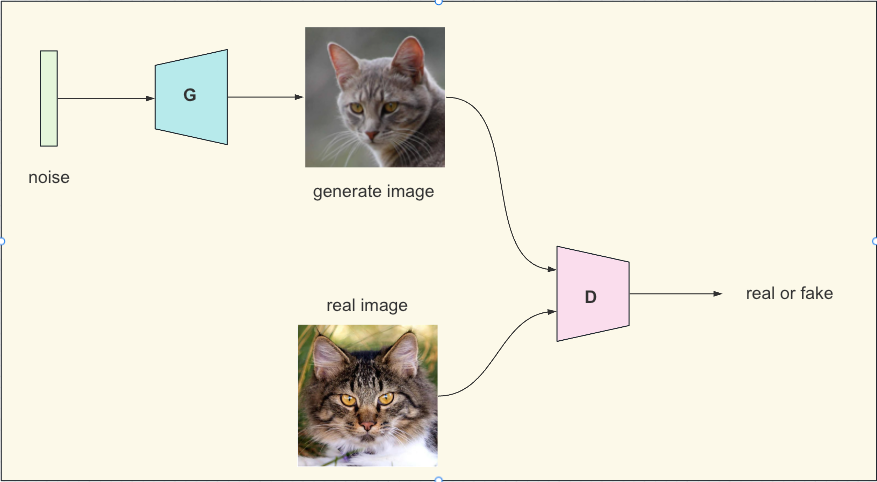

## Import library

In [72]:
import os
import time
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Load  data

In [70]:
def load_images_as_rgb_matrices(path, size):
    images = []
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = load_img(img_path, target_size=size)
        img_array = img_to_array(img)
        images.append(img_array)
    images = np.array(images)
    images = (images - 127.5) / 127.5  # Normalize images to [-1, 1]
    return images

In [71]:
cat_path = "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/afhq/train/cat"
size = (128, 128)
x_train = load_images_as_rgb_matrices(cat_path, size)

## Generator

In [28]:
# input 100
# output 128*128*3

def build_generator():
    model = Sequential()
    
    # Increase the dimension
    model.add(Dense(16*16*256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 256)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))  # 32x32
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))  # 64x64
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))  # 128x128
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(3, kernel_size=7, activation='tanh', padding='same'))  # 128x128x3

    return model


## Discriminator

In [52]:
# input 128*128*3
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(128, 128, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## Initial gan

In [ ]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(0.0002, 0.5))
    return gan

## Define train step

In [ ]:
def train(generator, discriminator, gan, x_train, epochs, batch_size=128):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        start_time = time.time()  

     
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, valid)

        end_time = time.time()  
        epoch_time = end_time - start_time  

        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}] [Epoch time: {epoch_time:.2f} seconds]")


## Train model

In [ ]:
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(0.0002, 0.5), metrics=['accuracy'])
gan = build_gan(generator, discriminator)

In [75]:
train(generator, discriminator, gan, x_train, epochs=1000, batch_size=64)

2/2 [==============================] - 1s 378ms/step


0 [D loss: 0.6956601440906525 | D accuracy: 27.34375] [G loss: 0.4139147102832794] [Epoch time: 4.73 seconds]
2/2 [==============================] - 1s 361ms/step
1 [D loss: 0.6063671112060547 | D accuracy: 50.0] [G loss: 0.20256102085113525] [Epoch time: 4.06 seconds]
2/2 [==============================] - 1s 364ms/step
2 [D loss: 0.5515194535255432 | D accuracy: 50.0] [G loss: 0.07102703303098679] [Epoch time: 4.01 seconds]
2/2 [==============================] - 1s 373ms/step
3 [D loss: 0.5008173137903214 | D accuracy: 50.0] [G loss: 0.029539838433265686] [Epoch time: 4.06 seconds]
2/2 [==============================] - 1s 387ms/step
4 [D loss: 0.42228011041879654 | D accuracy: 50.0] [G loss: 0.013372153043746948] [Epoch time: 4.07 seconds]
2/2 [==============================] - 1s 396ms/step
5 [D loss: 0.3376733213663101 | D accuracy: 100.0] [G loss: 0.004769905935972929] [Epoch time: 4.14 seconds]
2/2 [==============================] - 1s 382ms/step
6 [D loss: 0.23993065766990185 |

2/2 [==============================] - 1s 380ms/step
50 [D loss: 0.6585527658462524 | D accuracy: 60.15625] [G loss: 1.585690975189209] [Epoch time: 3.95 seconds]
2/2 [==============================] - 1s 356ms/step
51 [D loss: 0.5931712985038757 | D accuracy: 58.59375] [G loss: 1.5496392250061035] [Epoch time: 3.90 seconds]
2/2 [==============================] - 1s 376ms/step
52 [D loss: 0.6538150757551193 | D accuracy: 59.375] [G loss: 1.3331047296524048] [Epoch time: 3.94 seconds]
2/2 [==============================] - 1s 362ms/step
53 [D loss: 0.6821404993534088 | D accuracy: 51.5625] [G loss: 1.5409499406814575] [Epoch time: 3.92 seconds]
2/2 [==============================] - 1s 357ms/step
54 [D loss: 0.6001087427139282 | D accuracy: 57.8125] [G loss: 1.639374017715454] [Epoch time: 4.01 seconds]
2/2 [==============================] - 1s 383ms/step
55 [D loss: 0.6771350800991058 | D accuracy: 57.8125] [G loss: 1.5687611103057861] [Epoch time: 3.98 seconds]
2/2 [==================

2/2 [==============================] - 1s 358ms/step
101 [D loss: 0.5838743448257446 | D accuracy: 65.625] [G loss: 1.4768561124801636] [Epoch time: 3.87 seconds]
2/2 [==============================] - 1s 359ms/step
102 [D loss: 0.5811507403850555 | D accuracy: 68.75] [G loss: 1.3785808086395264] [Epoch time: 3.89 seconds]
2/2 [==============================] - 1s 357ms/step
103 [D loss: 0.5405526608228683 | D accuracy: 77.34375] [G loss: 1.592529058456421] [Epoch time: 3.90 seconds]
2/2 [==============================] - 1s 354ms/step
104 [D loss: 0.57611483335495 | D accuracy: 68.75] [G loss: 1.4973257780075073] [Epoch time: 3.93 seconds]
2/2 [==============================] - 1s 353ms/step
105 [D loss: 0.5575758218765259 | D accuracy: 73.4375] [G loss: 1.5223586559295654] [Epoch time: 3.96 seconds]
2/2 [==============================] - 1s 364ms/step
106 [D loss: 0.540233701467514 | D accuracy: 75.0] [G loss: 1.5545132160186768] [Epoch time: 3.94 seconds]
2/2 [======================

2/2 [==============================] - 1s 374ms/step
151 [D loss: 0.5573218464851379 | D accuracy: 71.875] [G loss: 1.2593754529953003] [Epoch time: 4.11 seconds]
2/2 [==============================] - 1s 388ms/step
152 [D loss: 0.5990175008773804 | D accuracy: 75.0] [G loss: 1.2355124950408936] [Epoch time: 4.07 seconds]
2/2 [==============================] - 1s 365ms/step
153 [D loss: 0.6112441420555115 | D accuracy: 69.53125] [G loss: 1.0296709537506104] [Epoch time: 4.04 seconds]
2/2 [==============================] - 1s 369ms/step
154 [D loss: 0.5812417268753052 | D accuracy: 75.78125] [G loss: 1.0948293209075928] [Epoch time: 3.97 seconds]
2/2 [==============================] - 1s 363ms/step
155 [D loss: 0.6797009706497192 | D accuracy: 54.6875] [G loss: 0.9526108503341675] [Epoch time: 3.95 seconds]
2/2 [==============================] - 1s 380ms/step
156 [D loss: 0.5037121772766113 | D accuracy: 82.03125] [G loss: 1.349064826965332] [Epoch time: 4.02 seconds]
2/2 [=============

2/2 [==============================] - 1s 380ms/step
201 [D loss: 0.5487367808818817 | D accuracy: 76.5625] [G loss: 1.3470263481140137] [Epoch time: 4.05 seconds]
2/2 [==============================] - 1s 410ms/step
202 [D loss: 0.5257910937070847 | D accuracy: 79.6875] [G loss: 1.3785098791122437] [Epoch time: 4.28 seconds]
2/2 [==============================] - 1s 389ms/step
203 [D loss: 0.5626094341278076 | D accuracy: 71.875] [G loss: 1.4778509140014648] [Epoch time: 4.16 seconds]
2/2 [==============================] - 1s 390ms/step
204 [D loss: 0.5608784556388855 | D accuracy: 67.1875] [G loss: 1.385919451713562] [Epoch time: 4.26 seconds]
2/2 [==============================] - 1s 379ms/step
205 [D loss: 0.5430740416049957 | D accuracy: 73.4375] [G loss: 1.2890902757644653] [Epoch time: 4.23 seconds]
2/2 [==============================] - 1s 382ms/step
206 [D loss: 0.6001999378204346 | D accuracy: 67.1875] [G loss: 1.2788641452789307] [Epoch time: 4.40 seconds]
2/2 [=============

2/2 [==============================] - 1s 410ms/step
251 [D loss: 0.6670341491699219 | D accuracy: 56.25] [G loss: 0.976905345916748] [Epoch time: 4.25 seconds]
2/2 [==============================] - 1s 378ms/step
252 [D loss: 0.6207936108112335 | D accuracy: 65.625] [G loss: 1.0369935035705566] [Epoch time: 4.26 seconds]
2/2 [==============================] - 1s 400ms/step
253 [D loss: 0.589352160692215 | D accuracy: 66.40625] [G loss: 1.0905917882919312] [Epoch time: 4.24 seconds]
2/2 [==============================] - 1s 390ms/step
254 [D loss: 0.6464007794857025 | D accuracy: 65.625] [G loss: 1.0745267868041992] [Epoch time: 4.31 seconds]
2/2 [==============================] - 1s 395ms/step
255 [D loss: 0.6297198235988617 | D accuracy: 67.96875] [G loss: 1.1136066913604736] [Epoch time: 4.14 seconds]
2/2 [==============================] - 1s 387ms/step
256 [D loss: 0.5993334949016571 | D accuracy: 64.84375] [G loss: 1.090227484703064] [Epoch time: 4.18 seconds]
2/2 [===============

2/2 [==============================] - 1s 394ms/step
301 [D loss: 0.6401340663433075 | D accuracy: 61.71875] [G loss: 0.8007142543792725] [Epoch time: 4.17 seconds]
2/2 [==============================] - 1s 368ms/step
302 [D loss: 0.6532409191131592 | D accuracy: 63.28125] [G loss: 0.7593420743942261] [Epoch time: 4.20 seconds]
2/2 [==============================] - 1s 391ms/step
303 [D loss: 0.6212558150291443 | D accuracy: 65.625] [G loss: 0.8711389303207397] [Epoch time: 4.16 seconds]
2/2 [==============================] - 1s 386ms/step
304 [D loss: 0.6299916505813599 | D accuracy: 62.5] [G loss: 0.8668172359466553] [Epoch time: 4.14 seconds]
2/2 [==============================] - 1s 413ms/step
305 [D loss: 0.607154369354248 | D accuracy: 67.1875] [G loss: 0.9220242500305176] [Epoch time: 4.20 seconds]
2/2 [==============================] - 1s 391ms/step
306 [D loss: 0.6361717283725739 | D accuracy: 63.28125] [G loss: 0.9508628845214844] [Epoch time: 4.15 seconds]
2/2 [=============

2/2 [==============================] - 1s 423ms/step
351 [D loss: 0.6059477031230927 | D accuracy: 65.625] [G loss: 1.0260359048843384] [Epoch time: 4.41 seconds]
2/2 [==============================] - 1s 413ms/step
352 [D loss: 0.6681905388832092 | D accuracy: 55.46875] [G loss: 0.9055465459823608] [Epoch time: 4.34 seconds]
2/2 [==============================] - 1s 420ms/step
353 [D loss: 0.6700632274150848 | D accuracy: 53.90625] [G loss: 0.8538339138031006] [Epoch time: 4.20 seconds]
2/2 [==============================] - 1s 376ms/step
354 [D loss: 0.6443657577037811 | D accuracy: 60.15625] [G loss: 0.8951811790466309] [Epoch time: 4.17 seconds]
2/2 [==============================] - 1s 433ms/step
355 [D loss: 0.6540288329124451 | D accuracy: 60.15625] [G loss: 0.9028509855270386] [Epoch time: 4.15 seconds]
2/2 [==============================] - 1s 378ms/step
356 [D loss: 0.6482593417167664 | D accuracy: 59.375] [G loss: 0.8613139390945435] [Epoch time: 4.00 seconds]
2/2 [=========

2/2 [==============================] - 1s 374ms/step
401 [D loss: 0.6364908218383789 | D accuracy: 67.1875] [G loss: 0.869009256362915] [Epoch time: 4.30 seconds]
2/2 [==============================] - 1s 408ms/step
402 [D loss: 0.6292335987091064 | D accuracy: 64.0625] [G loss: 0.8394195437431335] [Epoch time: 4.16 seconds]
2/2 [==============================] - 1s 362ms/step
403 [D loss: 0.6506417393684387 | D accuracy: 61.71875] [G loss: 0.7541772723197937] [Epoch time: 4.22 seconds]
2/2 [==============================] - 1s 389ms/step
404 [D loss: 0.6831153035163879 | D accuracy: 53.90625] [G loss: 0.7452897429466248] [Epoch time: 4.34 seconds]
2/2 [==============================] - 1s 414ms/step
405 [D loss: 0.664172351360321 | D accuracy: 54.6875] [G loss: 0.778376579284668] [Epoch time: 4.71 seconds]
2/2 [==============================] - 1s 420ms/step
406 [D loss: 0.6486647129058838 | D accuracy: 68.75] [G loss: 0.8528984189033508] [Epoch time: 5.20 seconds]
2/2 [==============

2/2 [==============================] - 1s 363ms/step
451 [D loss: 0.6286163628101349 | D accuracy: 69.53125] [G loss: 0.8966705203056335] [Epoch time: 3.95 seconds]
2/2 [==============================] - 1s 359ms/step
452 [D loss: 0.5655999779701233 | D accuracy: 84.375] [G loss: 0.9882375001907349] [Epoch time: 3.93 seconds]
2/2 [==============================] - 1s 363ms/step
453 [D loss: 0.5880169570446014 | D accuracy: 78.90625] [G loss: 0.9912141561508179] [Epoch time: 3.93 seconds]
2/2 [==============================] - 1s 361ms/step
454 [D loss: 0.5847349166870117 | D accuracy: 75.0] [G loss: 0.9084501266479492] [Epoch time: 4.00 seconds]
2/2 [==============================] - 1s 373ms/step
455 [D loss: 0.6528114080429077 | D accuracy: 59.375] [G loss: 0.8635857701301575] [Epoch time: 3.99 seconds]
2/2 [==============================] - 1s 355ms/step
456 [D loss: 0.6442337036132812 | D accuracy: 62.5] [G loss: 0.939049243927002] [Epoch time: 3.95 seconds]
2/2 [==================

2/2 [==============================] - 1s 359ms/step
501 [D loss: 0.5972273945808411 | D accuracy: 71.09375] [G loss: 0.9646420478820801] [Epoch time: 3.94 seconds]
2/2 [==============================] - 1s 355ms/step
502 [D loss: 0.6328994035720825 | D accuracy: 67.96875] [G loss: 0.874481201171875] [Epoch time: 3.94 seconds]
2/2 [==============================] - 1s 358ms/step
503 [D loss: 0.6305620670318604 | D accuracy: 63.28125] [G loss: 0.8925935626029968] [Epoch time: 3.93 seconds]
2/2 [==============================] - 1s 362ms/step
504 [D loss: 0.6413678228855133 | D accuracy: 62.5] [G loss: 0.8723785877227783] [Epoch time: 3.98 seconds]
2/2 [==============================] - 1s 356ms/step
505 [D loss: 0.626295804977417 | D accuracy: 64.0625] [G loss: 0.8271206021308899] [Epoch time: 3.92 seconds]
2/2 [==============================] - 1s 357ms/step
506 [D loss: 0.6183313727378845 | D accuracy: 64.0625] [G loss: 0.8216016292572021] [Epoch time: 3.93 seconds]
2/2 [=============

2/2 [==============================] - 1s 357ms/step
551 [D loss: 0.6026529967784882 | D accuracy: 70.3125] [G loss: 1.0344829559326172] [Epoch time: 4.03 seconds]
2/2 [==============================] - 1s 359ms/step
552 [D loss: 0.5493146479129791 | D accuracy: 72.65625] [G loss: 1.0514816045761108] [Epoch time: 3.97 seconds]
2/2 [==============================] - 1s 356ms/step
553 [D loss: 0.5866343677043915 | D accuracy: 75.0] [G loss: 1.0794181823730469] [Epoch time: 3.96 seconds]
2/2 [==============================] - 1s 363ms/step
554 [D loss: 0.5963756442070007 | D accuracy: 64.0625] [G loss: 0.9907825589179993] [Epoch time: 3.93 seconds]
2/2 [==============================] - 1s 360ms/step
555 [D loss: 0.6694198846817017 | D accuracy: 60.9375] [G loss: 0.9734140634536743] [Epoch time: 3.90 seconds]
2/2 [==============================] - 1s 352ms/step
556 [D loss: 0.6602968871593475 | D accuracy: 57.03125] [G loss: 1.0960664749145508] [Epoch time: 3.97 seconds]
2/2 [============

2/2 [==============================] - 1s 358ms/step
601 [D loss: 0.6758373379707336 | D accuracy: 59.375] [G loss: 0.923862636089325] [Epoch time: 3.95 seconds]
2/2 [==============================] - 1s 364ms/step
602 [D loss: 0.6493790149688721 | D accuracy: 61.71875] [G loss: 0.99947190284729] [Epoch time: 3.96 seconds]
2/2 [==============================] - 1s 375ms/step
603 [D loss: 0.6052225828170776 | D accuracy: 59.375] [G loss: 1.1748127937316895] [Epoch time: 3.97 seconds]
2/2 [==============================] - 1s 366ms/step
604 [D loss: 0.6395367383956909 | D accuracy: 65.625] [G loss: 0.8191972374916077] [Epoch time: 4.05 seconds]
2/2 [==============================] - 1s 400ms/step
605 [D loss: 0.6451696753501892 | D accuracy: 56.25] [G loss: 0.8752477169036865] [Epoch time: 5.36 seconds]
2/2 [==============================] - 1s 417ms/step
606 [D loss: 0.6641820669174194 | D accuracy: 58.59375] [G loss: 0.9359800815582275] [Epoch time: 4.44 seconds]
2/2 [=================

2/2 [==============================] - 1s 385ms/step
651 [D loss: 0.6093272864818573 | D accuracy: 71.875] [G loss: 0.9827116131782532] [Epoch time: 4.09 seconds]
2/2 [==============================] - 1s 394ms/step
652 [D loss: 0.6855384409427643 | D accuracy: 50.78125] [G loss: 0.9518652558326721] [Epoch time: 4.27 seconds]
2/2 [==============================] - 1s 403ms/step
653 [D loss: 0.6226324439048767 | D accuracy: 67.1875] [G loss: 1.0349600315093994] [Epoch time: 4.12 seconds]
2/2 [==============================] - 1s 363ms/step
654 [D loss: 0.6661364734172821 | D accuracy: 58.59375] [G loss: 0.9687932729721069] [Epoch time: 4.12 seconds]
2/2 [==============================] - 1s 366ms/step
655 [D loss: 0.6622107326984406 | D accuracy: 60.9375] [G loss: 0.9210894107818604] [Epoch time: 4.28 seconds]
2/2 [==============================] - 1s 397ms/step
656 [D loss: 0.6958420872688293 | D accuracy: 57.8125] [G loss: 1.0004098415374756] [Epoch time: 4.17 seconds]
2/2 [==========

2/2 [==============================] - 1s 438ms/step
701 [D loss: 0.2833315283060074 | D accuracy: 92.96875] [G loss: 2.622204542160034] [Epoch time: 4.20 seconds]
2/2 [==============================] - 1s 357ms/step
702 [D loss: 0.7765862047672272 | D accuracy: 49.21875] [G loss: 1.0096714496612549] [Epoch time: 4.07 seconds]
2/2 [==============================] - 1s 363ms/step
703 [D loss: 0.5237149447202682 | D accuracy: 82.03125] [G loss: 1.664632797241211] [Epoch time: 4.23 seconds]
2/2 [==============================] - 1s 398ms/step
704 [D loss: 0.5315015912055969 | D accuracy: 75.78125] [G loss: 1.3801361322402954] [Epoch time: 4.02 seconds]
2/2 [==============================] - 1s 386ms/step
705 [D loss: 0.6068914234638214 | D accuracy: 59.375] [G loss: 1.1510303020477295] [Epoch time: 4.14 seconds]
2/2 [==============================] - 1s 370ms/step
706 [D loss: 0.393852174282074 | D accuracy: 91.40625] [G loss: 1.6657795906066895] [Epoch time: 4.14 seconds]
2/2 [==========

2/2 [==============================] - 1s 359ms/step
751 [D loss: 0.6222465634346008 | D accuracy: 57.8125] [G loss: 1.5358991622924805] [Epoch time: 3.91 seconds]
2/2 [==============================] - 1s 365ms/step
752 [D loss: 0.6508963406085968 | D accuracy: 71.875] [G loss: 1.2346467971801758] [Epoch time: 3.93 seconds]
2/2 [==============================] - 1s 354ms/step
753 [D loss: 0.6549860537052155 | D accuracy: 67.1875] [G loss: 1.1487866640090942] [Epoch time: 3.94 seconds]
2/2 [==============================] - 1s 363ms/step
754 [D loss: 0.5894007980823517 | D accuracy: 68.75] [G loss: 1.158332109451294] [Epoch time: 3.92 seconds]
2/2 [==============================] - 1s 354ms/step
755 [D loss: 0.556304544210434 | D accuracy: 78.125] [G loss: 1.3316195011138916] [Epoch time: 3.92 seconds]
2/2 [==============================] - 1s 355ms/step
756 [D loss: 0.5180179327726364 | D accuracy: 80.46875] [G loss: 1.2899324893951416] [Epoch time: 3.96 seconds]
2/2 [================

2/2 [==============================] - 1s 360ms/step
801 [D loss: 0.6331887543201447 | D accuracy: 64.0625] [G loss: 1.2396183013916016] [Epoch time: 3.99 seconds]
2/2 [==============================] - 1s 358ms/step
802 [D loss: 0.6623473763465881 | D accuracy: 63.28125] [G loss: 1.0661824941635132] [Epoch time: 3.93 seconds]
2/2 [==============================] - 1s 360ms/step
803 [D loss: 0.6813612282276154 | D accuracy: 53.125] [G loss: 1.0595922470092773] [Epoch time: 3.97 seconds]
2/2 [==============================] - 1s 364ms/step
804 [D loss: 0.5915317535400391 | D accuracy: 74.21875] [G loss: 1.1027352809906006] [Epoch time: 3.99 seconds]
2/2 [==============================] - 1s 358ms/step
805 [D loss: 0.5861200243234634 | D accuracy: 73.4375] [G loss: 1.4117375612258911] [Epoch time: 3.91 seconds]
2/2 [==============================] - 1s 362ms/step
806 [D loss: 0.3366135284304619 | D accuracy: 84.375] [G loss: 3.2638306617736816] [Epoch time: 3.91 seconds]
2/2 [===========

2/2 [==============================] - 1s 365ms/step
851 [D loss: 0.5801869034767151 | D accuracy: 72.65625] [G loss: 1.0524582862854004] [Epoch time: 3.90 seconds]
2/2 [==============================] - 1s 361ms/step
852 [D loss: 0.5917023420333862 | D accuracy: 68.75] [G loss: 1.0373287200927734] [Epoch time: 3.91 seconds]
2/2 [==============================] - 1s 363ms/step
853 [D loss: 0.5957719087600708 | D accuracy: 67.96875] [G loss: 1.1771104335784912] [Epoch time: 3.92 seconds]
2/2 [==============================] - 1s 356ms/step
854 [D loss: 0.6532210111618042 | D accuracy: 60.15625] [G loss: 1.0166497230529785] [Epoch time: 3.91 seconds]
2/2 [==============================] - 1s 357ms/step
855 [D loss: 0.644514262676239 | D accuracy: 66.40625] [G loss: 0.9438927173614502] [Epoch time: 3.90 seconds]
2/2 [==============================] - 1s 354ms/step
856 [D loss: 0.6425956785678864 | D accuracy: 59.375] [G loss: 1.0382542610168457] [Epoch time: 3.90 seconds]
2/2 [===========

2/2 [==============================] - 1s 355ms/step
901 [D loss: 0.8094911873340607 | D accuracy: 43.75] [G loss: 1.0189785957336426] [Epoch time: 3.90 seconds]
2/2 [==============================] - 1s 375ms/step
902 [D loss: 0.7370783090591431 | D accuracy: 47.65625] [G loss: 0.9889419078826904] [Epoch time: 3.94 seconds]
2/2 [==============================] - 1s 356ms/step
903 [D loss: 0.6737889647483826 | D accuracy: 55.46875] [G loss: 0.9575725197792053] [Epoch time: 3.91 seconds]
2/2 [==============================] - 1s 357ms/step
904 [D loss: 0.5904685258865356 | D accuracy: 68.75] [G loss: 1.078157901763916] [Epoch time: 4.02 seconds]
2/2 [==============================] - 1s 370ms/step
905 [D loss: 0.5801289677619934 | D accuracy: 71.09375] [G loss: 1.1259979009628296] [Epoch time: 3.93 seconds]
2/2 [==============================] - 1s 356ms/step
906 [D loss: 0.5936659872531891 | D accuracy: 70.3125] [G loss: 1.1532357931137085] [Epoch time: 3.95 seconds]
2/2 [=============

2/2 [==============================] - 1s 374ms/step
951 [D loss: 0.6752056181430817 | D accuracy: 58.59375] [G loss: 0.938356339931488] [Epoch time: 3.98 seconds]
2/2 [==============================] - 1s 391ms/step
952 [D loss: 0.6646667122840881 | D accuracy: 55.46875] [G loss: 1.0066683292388916] [Epoch time: 4.02 seconds]
2/2 [==============================] - 1s 395ms/step
953 [D loss: 0.6489013731479645 | D accuracy: 60.9375] [G loss: 0.9694200754165649] [Epoch time: 4.35 seconds]
2/2 [==============================] - 1s 392ms/step
954 [D loss: 0.6438833475112915 | D accuracy: 58.59375] [G loss: 1.032991647720337] [Epoch time: 4.19 seconds]
2/2 [==============================] - 1s 400ms/step
955 [D loss: 0.625264048576355 | D accuracy: 66.40625] [G loss: 0.9718813896179199] [Epoch time: 4.21 seconds]
2/2 [==============================] - 1s 381ms/step
956 [D loss: 0.6023145914077759 | D accuracy: 68.75] [G loss: 1.0801458358764648] [Epoch time: 4.18 seconds]
2/2 [============

## Test

In [76]:
def show_generated_images(generator, num_images=25, dim=(5, 5), figsize=(10, 10)):
    noise = np.random.normal(0, 1, (num_images, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    plt.figure(figsize=figsize)
    for i in range(num_images):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(gen_imgs[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 337ms/step


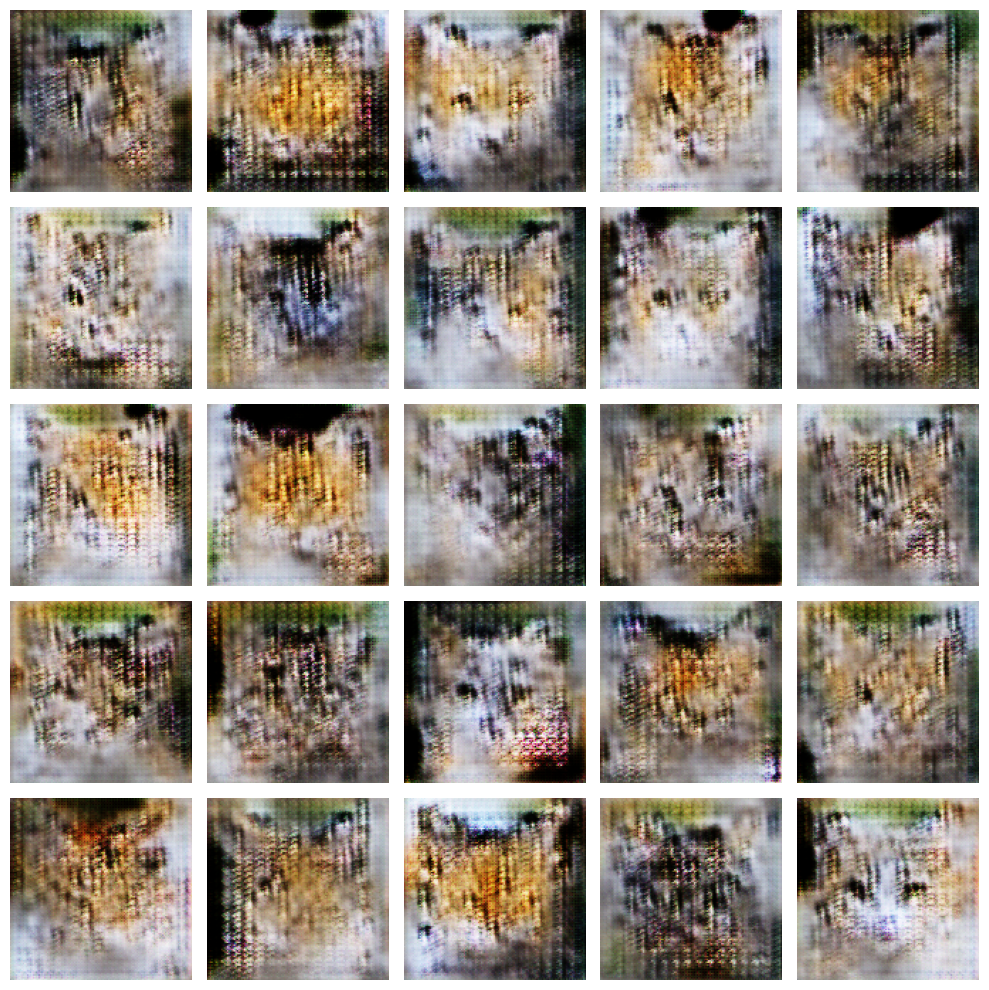

In [77]:
show_generated_images(generator)